In [7]:
# conda install -c conda-forge ipywidgets

In [8]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from dataset.dataset_loader import SNDataset, myNormalize, myToTensor
from torchvision import transforms

In [9]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
#mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)], [(12), (-4,2963)], [(13), (0, 90)]], oc_min = 0, oc_max = 200)
mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)]], oc_min = 0, oc_max = 200)
my_to_tensor = myToTensor()
transform = transforms.Compose([mynorm, my_to_tensor])

In [11]:
bands = [0,1,2,3,4,5,6,7,8,9,10,11]
# train_ds = SNDataset('D:\python\SoilNet\dataset\l8_images\\train\\','D:\python\SoilNet\dataset\LUCAS_2015_all.csv',l8_bands=bands, transform=transform)
train_ds = SNDataset('C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\l8_images\\train',\
                     'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\LUCAS_2015_all.csv',l8_bands=bands, transform=transform) #Nafiseh 

# test_ds = SNDataset('D:\python\SoilNet\dataset\l8_images\\test\\','D:\python\SoilNet\dataset\LUCAS_2015_all.csv',l8_bands=bands, transform=transform)
test_ds = SNDataset('C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\l8_images\\test',\
                     'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\LUCAS_2015_all.csv',l8_bands=bands, transform=transform) #Nafiseh 

In [13]:
# # CONFIG
# NUM_WORKERS = 2
# TRAIN_BATCH_SIZE = 8
# TEST_BATCH_SIZE = 2

# CONFIG
NUM_WORKERS = 6
TRAIN_BATCH_SIZE = 40
TEST_BATCH_SIZE = 10

In [14]:
train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dl = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [15]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dl))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([40, 12, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([40])


In [16]:
from soilnet.soil_net import SoilNetFC, ResNet

In [17]:
#model = SoilNetFC(cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
model = ResNet(resnet_architecture="101",cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
img_gpu = img_custom.to(device)
print(img_gpu.device, img_gpu.shape)
print(img_gpu.shape)
y = model(img_gpu)
y.detach()


cuda:0 torch.Size([40, 12, 64, 64])
torch.Size([40, 12, 64, 64])


tensor([[0.0581],
        [0.0487],
        [0.0625],
        [0.0740],
        [0.0630],
        [0.0331],
        [0.0390],
        [0.0668],
        [0.0355],
        [0.0803],
        [0.0762],
        [0.0633],
        [0.0645],
        [0.0693],
        [0.0673],
        [0.0681],
        [0.0690],
        [0.0159],
        [0.0462],
        [0.0558],
        [0.0891],
        [0.0701],
        [0.0668],
        [0.0595],
        [0.0517],
        [0.0548],
        [0.0688],
        [0.0756],
        [0.0596],
        [0.0599],
        [0.0640],
        [0.0835],
        [0.0903],
        [0.0892],
        [0.0509],
        [0.0803],
        [0.0767],
        [0.1005],
        [0.1114],
        [0.0712]], device='cuda:0')

In [18]:
torch.min(img_gpu[0]) , torch.min(img_gpu[1])

(tensor(0.0039, device='cuda:0'), tensor(0.0081, device='cuda:0'))

In [19]:
def train_step(model:nn.Module, data_loader:DataLoader, loss_fn:nn.Module, optimizer:torch.optim.Optimizer):
    size = len(data_loader.dataset)
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss = 0
    
    for batch, (X, y) in enumerate(data_loader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)


        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 


        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    train_loss = train_loss / len(data_loader)
    return train_loss

In [20]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [21]:
# x= train_step(model, train_dl, RMSELoss(), torch.optim.Adam(model.parameters(), lr=1e-4))
# x

In [22]:
# Test step function
def test_step(model:nn.Module, data_loader:DataLoader, loss_fn:nn.Module):
    size = len(data_loader.dataset)
    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            # if batch % 2 == 0:
            #     loss, current = loss.item(), batch * len(X)
            #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    test_loss /= len(data_loader)
    print(f"Test Loss: {test_loss:>8f}%")
    return test_loss

In [23]:
# x= test_step(model, test_dl, RMSELoss())
# x

In [24]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = RMSELoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "test_loss": [],
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss = test_step(model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | ",
            f"train_loss: {train_loss} | ",
            f"test_loss: {test_loss} | "
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # 6. Return the filled results at the end of the epochs
    return results

## ~~Model is to Small it can't even overfit! | try RESNET~~
## A lower learning rate (1e-5) solved out problem!

In [25]:
results = train(model, train_dl, test_dl, torch.optim.Adam(model.parameters(), lr=1e-6), RMSELoss(), epochs=10) # Make| sure set shuffle for train back to True after testing

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\nkakhani\anaconda3\envs\pytorchGPU\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.262164  [    0/15296]
loss: 0.128228  [   80/15296]
loss: 0.272501  [  160/15296]
loss: 0.110108  [  240/15296]
loss: 0.170466  [  320/15296]
loss: 0.313222  [  400/15296]
loss: 0.247358  [  480/15296]
loss: 0.311356  [  560/15296]
loss: 0.311026  [  640/15296]
loss: 0.175252  [  720/15296]
loss: 0.170851  [  800/15296]
loss: 0.306202  [  880/15296]
loss: 0.277061  [  960/15296]
loss: 0.281729  [ 1040/15296]
loss: 0.180702  [ 1120/15296]
loss: 0.182989  [ 1200/15296]
loss: 0.239269  [ 1280/15296]
loss: 0.211538  [ 1360/15296]
loss: 0.196537  [ 1440/15296]
loss: 0.244849  [ 1520/15296]
loss: 0.288492  [ 1600/15296]
loss: 0.204621  [ 1680/15296]
loss: 0.314439  [ 1760/15296]
loss: 0.106161  [ 1840/15296]
loss: 0.328589  [ 1920/15296]
loss: 0.281972  [ 2000/15296]
loss: 0.231625  [ 2080/15296]
loss: 0.253049  [ 2160/15296]
loss: 0.249226  [ 2240/15296]
loss: 0.273661  [ 2320/15296]
loss: 0.253644  [ 2400/15296]
loss: 0.188450  [ 2480/15296]
loss: 0.179007  [ 2560/15296]
loss: 0.18

c:\Users\nkakhani\anaconda3\envs\pytorchGPU\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\nkakhani\anaconda3\envs\pytorchGPU\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\nkakhani\anaconda3\envs\pytorchGPU\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. P

Test Loss: 0.190745%
Epoch: 1 |  train_loss: 0.2124485336924969 |  test_loss: 0.19074469124345475 | 
loss: 0.226012  [    0/15296]
loss: 0.103859  [   80/15296]
loss: 0.188940  [  160/15296]
loss: 0.234730  [  240/15296]
loss: 0.160507  [  320/15296]
loss: 0.097801  [  400/15296]
loss: 0.181355  [  480/15296]
loss: 0.229649  [  560/15296]
loss: 0.214906  [  640/15296]
loss: 0.259706  [  720/15296]
loss: 0.195027  [  800/15296]
loss: 0.142075  [  880/15296]
loss: 0.216346  [  960/15296]
loss: 0.177041  [ 1040/15296]
loss: 0.220427  [ 1120/15296]
loss: 0.222111  [ 1200/15296]
loss: 0.184099  [ 1280/15296]
loss: 0.243941  [ 1360/15296]
loss: 0.186323  [ 1440/15296]
loss: 0.164113  [ 1520/15296]
loss: 0.180122  [ 1600/15296]
loss: 0.177560  [ 1680/15296]
loss: 0.086970  [ 1760/15296]
loss: 0.299391  [ 1840/15296]
loss: 0.129401  [ 1920/15296]
loss: 0.286828  [ 2000/15296]
loss: 0.125230  [ 2080/15296]
loss: 0.163177  [ 2160/15296]
loss: 0.174043  [ 2240/15296]
loss: 0.218924  [ 2320/15296]

KeyboardInterrupt: 

In [55]:
import matplotlib.pyplot as plt

def plot_losses(loss_dict):
    train_losses = loss_dict["train_loss"]
    test_losses = loss_dict["test_loss"]
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.title("Training and Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

somehow the test_loss is smaller than train_loss -> could be due to small smaple dataset

In [56]:
%matplotlib inline

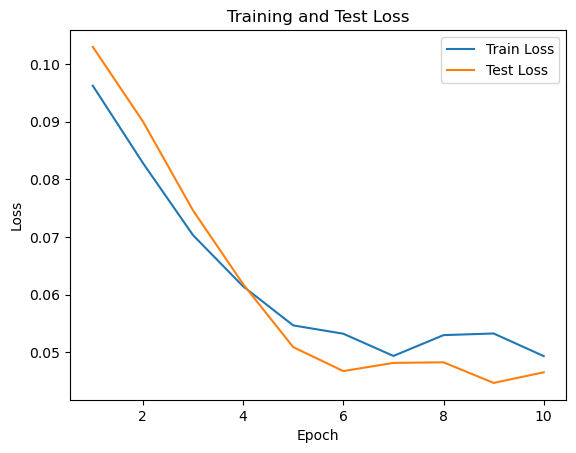

In [57]:
plot_losses(results)